In [1]:
# returns banana 2-dim density and sampler
import numpy as np
from scipy.special import gamma
import scipy.stats as stats
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd

<function matplotlib.pyplot.show(close=None, block=None)>

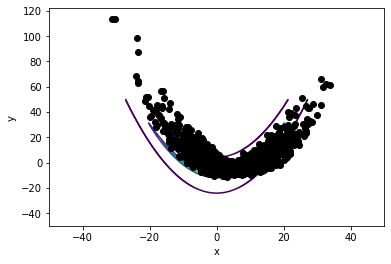

In [3]:
b = 0.1
def p_aux(x, K):
    banana = tfp.experimental.inference_gym.targets.Banana(
        ndims=K, curvature=b, name='banana', pretty_name='Banana'
    )
    return np.array(np.exp(banana.unnormalized_log_prob(x)))
def p(x): return p_aux(x, 2)

def sample(size, K, noise = 10):
    banana = tfp.experimental.inference_gym.targets.Banana(
        ndims=K, curvature=b, name='banana', pretty_name='Banana'
    )
    return np.array(banana.sample(sample_shape=(size)) + noise*np.random.rand(size, K))

len = 1000
xx = np.linspace(-50, 50, len)
yy = np.linspace(-50, 50, len)
tt = np.array(np.meshgrid(xx, yy)).T.reshape(len**2, 2)
zz = p(tt).reshape(len, len).T

ss = sample(1000, 2)

#print(tt, tt2, zz2, zz3)
plt.contour(xx, yy, zz)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(ss[:, 0], ss[:, 1], 'ok')
plt.show

In [2]:
def norm_logpdf(x, loc = np.array([0]).reshape(1, 1), scale = np.array([1])):
    """
    evaluate isotropic normal logpdf at x with mean loc and sd scale

    - x is an (m+1)d array, where the last dimension accounts for multivariate x
        eg x[0, 0,..., 0, :] is the first observation and has shape K
    - loc is a shape(N, K) array
    - scale is a shape(N,). The covariance matrix is given by scale[i]**2 * np.diag(N) (ie Gaussians are isotropic)

    returns an md array with same shapes as x (except the last dimension)
    """
    K = x.shape[-1]

    return -0.5 * ((x[..., np.newaxis] - loc.T)**2).sum(axis = -2) / scale**2 - 0.5 * K *  np.log(2 * np.pi) - K * np.log(scale)
###########

###########
def mixture_rvs(size, w, x, rho):
    """
    draws a random sample of size size from the mixture defined by w, x, and rho
    x is a shape(N, K) array and w, rho are shape(N,) arrays
    returns a shape(size, K) array
    """
    N = x.shape[0]
    K = x.shape[1]

    inds = np.random.choice(N, size = size, p = w, replace = True) # indices that will be chosen

    #rand = np.random.multivariate_normal(mean = np.zeros(K), cov = np.eye(K), size = size) # sample from standard normal
    rand = np.random.randn(size, K) # sample from standard normal but more efficiently than as above

    # return scaled and translated random draws
    sigmas = rho[inds] # index std deviations for ease
    return rand * sigmas[:, np.newaxis] + x[inds, :]
###########




# CREATE DENSITY ####
def p_aux(x, K):
    # mixture settings
    mix_size = 5
    weights = np.arange(mix_size, 0, -1)**2
    weights = weights / np.sum(weights)
    means = np.repeat(3 * np.arange(mix_size), K).reshape(mix_size, K)
    sd = np.ones(mix_size) / 5

    # evaluate mixture
    ln = norm_logpdf(x, loc = means, scale = sd)
    target = np.log(weights) + ln  # log sum wn exp(ln) = log sum exp(log wn + ln)
    max_value = np.max(target, axis = -1) # max within last axis
    exp_sum = np.exp(target - max_value[..., np.newaxis]).sum(axis = -1)

    return max_value + np.log(exp_sum)
###

Text(0, 0.5, 'y')

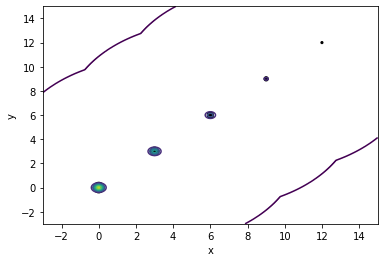

In [24]:
K = 2
def p(x): return p_aux(x, K)

xlim = np.array([-3, 15]) # for plotting
ylim = np.array([-3, 15]) # for plotting


w = np.arange(5, 0, -1)**2
w = w / np.sum(w)
x = np.repeat(3 * np.arange(5), K).reshape(5, K)

# initialize plot values
size = 2000
xx = np.linspace(xlim[0], xlim[1], size)
yy = np.linspace(ylim[0], ylim[1], size)
tt = np.array(np.meshgrid(xx, yy)).T.reshape(size**2, 2)
ff = np.exp(p(tt))
f = ff.reshape(size, size)

df = pd.DataFrame({'x': tt[:, 0], 'y': tt[:, 1], 'f': ff})
#print(df)
print()
#print(f)

# plot
plt.contour(yy, xx,f)
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.scatter(x[:, 0], x[:, 1], s = 1000*w, marker='.', c='k')

# save plot
plt.xlabel('x')
plt.ylabel('y')
#plt.title('mixture contour plot for N = ' + str(N))
#title = 'contour_N' + str(N) + '.'

projected mean: 0.0
projected sd: 14.389345141724508


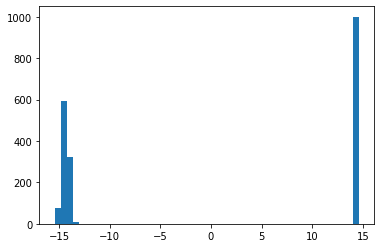


projected mean: 0.0
projected sd: 14.431356952164894


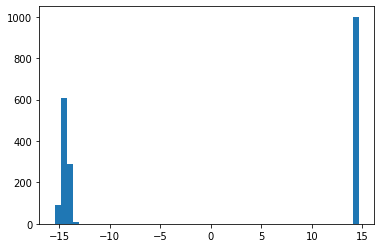


projected mean: 0.0
projected sd: 14.098023500970596


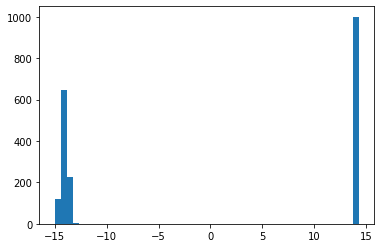


projected mean: -9.094947017729283e-16
projected sd: 14.13233064242166


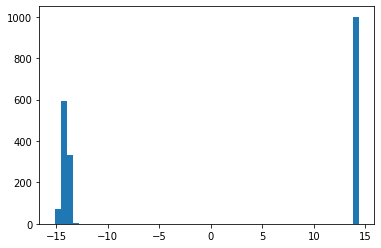


projected mean: 0.0
projected sd: 14.398301029969684


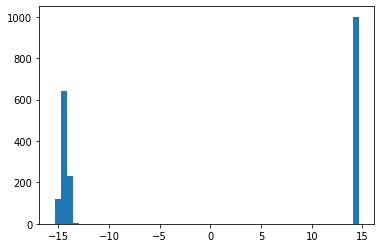

In [46]:
n = 1000 # sample size
k = 1000  # dimension
t = 5    # number of random projections

# synthetic data
x1 = np.random.gamma(shape = 10, scale = 3.7, size = (n, k))
x2 = -np.random.gamma(shape = 6, scale = 19, size = (n, k))
x = np.append(x1, x2, axis = 0)
theta = np.random.rand(t, k)

# plot
for i in range(t):
    tmp_theta = theta[i, :].reshape(k) # direction
    tmp_x = (x - np.mean(x, axis = 0)) / (np.std(x, axis = 0) * np.sqrt(k)) # normalize x
    x_proj = tmp_x.dot(tmp_theta) # project normalized data
    print('projected mean: ' + str(np.mean(x_proj)))
    print('projected sd: ' + str(np.std(x_proj)))
    
    # plot
    plt.hist(x_proj, bins = 50)
    plt.show()
    print()
    